<h1>3-a: Transfer Learning through feature extraction from a CNN</h1>


Before stating the project, verify to be in a GPU envirornment and python 3:

Exécution -> Modifier le type d'exécution -> Type d'exécution = python3, Accélerateur matériel = GPU

In [ ]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

from sklearn.svm import LinearSVC

# Partie 1 : Architecture VGG16

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/GIm7wxiAZys/download?force=true -O car.jpg
!wget --content-disposition https://unsplash.com/photos/wH7Q603NhmM/download?force=true -O mont_saint_michelle.jpg
!wget --content-disposition https://unsplash.com/photos/UlipBbZpweg/download?force=true -O lion.jpg

--2023-01-16 16:19:01--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl [following]
--2023-01-16 16:19:01--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35454 (35K) [text/plain]
Saving to: ‘imagenet_classes.pkl’

imagenet_classes.pk 100%[===================>]  34.62K  --.-KB/s    in 0s      

2023-01-16 16:19:01 (84.8 MB/s) - ‘imagenet_classes.pkl’ saved [35454

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Image is a lion, king of beasts, Panthera leo


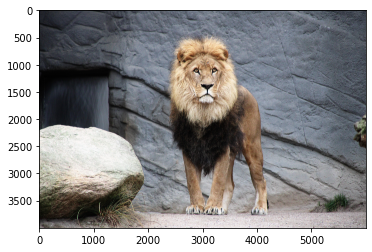

Image is a seashore, coast, seacoast, sea-coast


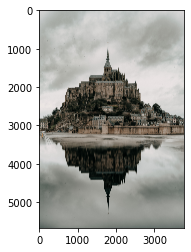

Image is a racer, race car, racing car


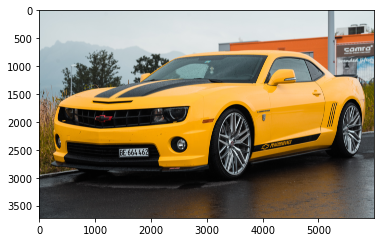

In [ ]:
# Ajoutez vos images
# VOTRE CODE ICI pour le bonus:
image_names = [jpg_file for jpg_file in os.listdir("./") if jpg_file.endswith(".jpg")]
vgg16 = torchvision.models.vgg16(pretrained=True)
imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb')) # chargement des classes

for name in image_names:
  img = Image.open(name)
  plt.imshow(img)

  img = img.resize((224, 224), Image.BILINEAR)
  img = np.array(img, dtype=np.float32) / 255
  img = img.transpose((2, 0, 1))

  img = np.expand_dims(img, 0)
  x = torch.Tensor(img)
  y = vgg16.forward(x)
  y = y.detach().numpy() # transformation en array numpy
  pred = imagenet_classes[y.argmax()]
  print(f"Image is a {pred}")

  plt.draw()
  plt.pause(1e-3)

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

!unzip 15ScenesData.zip

--2023-01-16 16:19:26--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip [following]
--2023-01-16 16:19:26--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86520868 (83M) [application/zip]
Saving to: ‘15ScenesData.zip’

15ScenesData.zip    100%[===================>]  82.51M   349MB/s    in 0.2s    

2023-01-16 16:19:27 (349 MB/s) - ‘15ScenesData.zip’ saved [86520868/86520868]

In [ ]:
!ls 15SceneData/test/bedroom/

image_0003.jpg	image_0042.jpg	image_0082.jpg	image_0124.jpg	image_0170.jpg
image_0004.jpg	image_0043.jpg	image_0084.jpg	image_0128.jpg	image_0175.jpg
image_0006.jpg	image_0047.jpg	image_0086.jpg	image_0130.jpg	image_0176.jpg
image_0007.jpg	image_0049.jpg	image_0087.jpg	image_0131.jpg	image_0180.jpg
image_0008.jpg	image_0050.jpg	image_0088.jpg	image_0134.jpg	image_0182.jpg
image_0011.jpg	image_0052.jpg	image_0090.jpg	image_0135.jpg	image_0189.jpg
image_0013.jpg	image_0053.jpg	image_0092.jpg	image_0138.jpg	image_0190.jpg
image_0014.jpg	image_0054.jpg	image_0093.jpg	image_0140.jpg	image_0191.jpg
image_0016.jpg	image_0056.jpg	image_0095.jpg	image_0141.jpg	image_0192.jpg
image_0017.jpg	image_0059.jpg	image_0096.jpg	image_0142.jpg	image_0195.jpg
image_0018.jpg	image_0060.jpg	image_0097.jpg	image_0144.jpg	image_0196.jpg
image_0019.jpg	image_0062.jpg	image_0098.jpg	image_0148.jpg	image_0200.jpg
image_0020.jpg	image_0063.jpg	image_0103.jpg	image_0150.jpg	image_0202.jpg
image_0021.jpg	image_0064

In [ ]:
class VGG16relu7(nn.Module):
  def __init__(self):
    super(VGG16relu7, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential( *list(vgg16.features.children()))
    # Keep a piece of the classifier: -2 to stop at relu7
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])
  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [ ]:

PRINT_INTERVAL = 50
CUDA = True

def get_dataset(batch_size, path):

    # Cette fonction permet de recopier 3 fois une image qui
    # ne serait que sur 1 channel (donc image niveau de gris)
    # pour la "transformer" en image RGB. Utilisez la avec
    # transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img

    #####################
    ## Votre code ici  ##
    #####################
    # Ajouter le pré-traitement
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([ # Pré-traitement à faire
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]))
    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([ # Pré-traitement à faire
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]))
    ####################
    ##      FIN        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [ ]:
def extract_features(data, model):
    #####################
    ## Votre code ici  ##
    #####################
    # init features matrices
    X = []
    y = []
    ####################
    ##      FIN        #
    ####################

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            input = input.cuda()
        #####################
        ## Votre code ici  ##
        #####################
        # Feature extraction à faire
        X.append(model.forward(input).cpu().detach())
        y.append(target)
        ####################
        ##      FIN        #
        ####################
    print(X[0].shape)
    print(y[0].shape)
    return X, y


def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    model = VGG16relu7()
    ####################
    ##      FIN        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    svm = LinearSVC(C=1.0)
    X_train = torch.cat(X_train)
    y_train = torch.cat(y_train)
    X_test = torch.cat(X_test)
    y_test = torch.cat(y_test)
    svm.fit(X_train, y_train)
    accuracy = svm.score(X_test, y_test) * 100

    ####################
    ##      FIN        #
    ####################
    print('Accuracy = %f' % accuracy)


In [ ]:
main("15SceneData", 8)

Instanciation de VGG16


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu7
Récupération des données
Feature extraction
Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188
torch.Size([8, 4096])
torch.Size([8])
Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
torch.Size([8, 4096])
torch.Size([8])
Apprentissage des SVM
Accuracy = 88.509213


/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
